# EDA
KSSL & LUCAS VNIR Exploratory Data Analysis (EDA)

In [3]:
%load_ext autoreload
%autoreload 2

In [15]:
from pathlib import Path

from fastai.vision.all import *
from fastai.data.all import *
from tqdm import tqdm
import timm

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression

import umap
from babyplots import Babyplot

from spanda.data.transforms import (SpectraBlock, AnalytesBlock, 
                                    AnalytesTfm, SNVTfm, AvgTfm, GADFTfm, 
                                    ResizeTfm, LogTfm, asTabular)

use_cuda = torch.cuda.is_available()
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'


import warnings
warnings.filterwarnings('ignore')

analyte_name = 725

## Configs

In [5]:
root_dir = Path('../../_data/') if device != 'cuda' else Path('.')

## Utilities

In [4]:
get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

def get_paths(src_dir, analytes=['725']):     
    path = Path(src_dir)
    
    # Only samples with spectra
    paths = [p for p in tqdm(path.ls()) if len(p.ls()) > 1]
    
    # Only strictly positive measurements
    paths = [p for p in tqdm(paths) if AnalytesTfm(analytes=analytes)(get_target(p)) > 0] 
    
    return L(paths)

def get_dls(paths, analytes=['725'], bs=32, seed=42):
    get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
    get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

    dblock = DataBlock(blocks=(SpectraBlock, AnalytesBlock(analytes=analytes)),
                       get_x=get_spectra,
                       get_y=get_target,
                       splitter=IndexSplitter([]),
                       item_tfms=[AvgTfm],
                       batch_tfms=[SNVTfm,
                                   LogTfm])

    return dblock.dataloaders(paths, bs=bs, num_workers=6)

## Data loading

In [5]:
analytes = ['725'] # Kex

paths_kssl = get_paths(root_dir/'kssl-vnir', analytes=analytes)
paths_lucas = get_paths(root_dir/'lucas-vnir', analytes=analytes)
paths_all = paths_kssl + paths_lucas; paths_all

100%|██████████| 21782/21782 [00:17<00:00, 1260.70it/s]


(#42728) [Path('../../_data/kssl-vnir/163161'),Path('../../_data/kssl-vnir/110493'),Path('../../_data/kssl-vnir/97322'),Path('../../_data/kssl-vnir/166413'),Path('../../_data/kssl-vnir/92650'),Path('../../_data/kssl-vnir/47957'),Path('../../_data/kssl-vnir/170576'),Path('../../_data/kssl-vnir/120206'),Path('../../_data/kssl-vnir/42419'),Path('../../_data/kssl-vnir/78584')...]

In [11]:
# Collate all KSSL & LUCAS data
(X_kssl, y_kssl), (X_lucas, y_lucas) = (asTabular(get_dls(p, bs=32).train) 
                                        for p in [paths_kssl, paths_lucas])

100%|██████████| 680/680 [01:04<00:00, 10.62it/s]


In [ ]:
fname_dump = Path('../files/dump') / 'vnir-all-tab.pkl'
save_pickle(fname_dump,
            ((X_kssl, y_kssl), (X_lucas, y_lucas)))

## Modeling

In [7]:
fname_dump = Path('../files/dump') / 'vnir-all-tab.pkl'
(X_kssl, y_kssl), (X_lucas, y_lucas) = load_pickle(fname_dump)

### Train test split

In [12]:
X, y = X_kssl, y_kssl
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.2, random_state=42)

print(f'# train: {len(X_train)}')
print(f'# test: {len(X_valid)}')

# train: 16742
# test: 4186


### PLSR

In [22]:
for n in range(10, 80, 10):
    plsr = PLSRegression(n_components=n)
    plsr.fit(X_train, y_train)
    score_train = r2_score(y_train, plsr.predict(X_train))
    score_valid = r2_score(y_valid, plsr.predict(X_valid))
    print(f'n_cpts: {n} \t| train: {score_train:.2} \t| valid: {score_valid:.2}')

n_cpts: 10 	| train: 0.34 	| valid: 0.34
n_cpts: 20 	| train: 0.4 	| valid: 0.4
n_cpts: 30 	| train: 0.42 	| valid: 0.42
n_cpts: 40 	| train: 0.44 	| valid: 0.44
n_cpts: 50 	| train: 0.47 	| valid: 0.44
n_cpts: 60 	| train: 0.49 	| valid: 0.44
n_cpts: 70 	| train: 0.51 	| valid: 0.45


### UMap

#### All wavelength

In [165]:
labels = np.r_[np.ones(len(X_kssl)) ,
               np.zeros(len(X_lucas))]

In [200]:
# Perform binning
num_bins = 2
bins, edges = np.histogram(y_kssl, bins=num_bins)

# Assign discrete labels based on binning
y_bin = np.digitize(y_kssl, edges)

print(f'bins: {bins}')
print(f'edges: {edges}')
print(f'edges (back-transformed): {10**edges}')

bins: [14092  6836]
edges: [-1.953946   -0.22216362  1.5096188 ]
edges (back-transformed): [1.1118700e-02 5.9956515e-01 3.2330971e+01]


In [167]:
X_kssl_umap = umap.UMAP(n_neighbors=25,
                      metric='cosine',
                      n_components=3).fit_transform(X_kssl, y=y_bin)

In [169]:
bp = Babyplot(background_color="#FFF", turntable=True)
bp.add_plot(X_kssl_umap, "pointCloud", "categories", 
            y_bin, {"colorScale": "Dark1"})
#bp

<IPython.core.display.Javascript object>

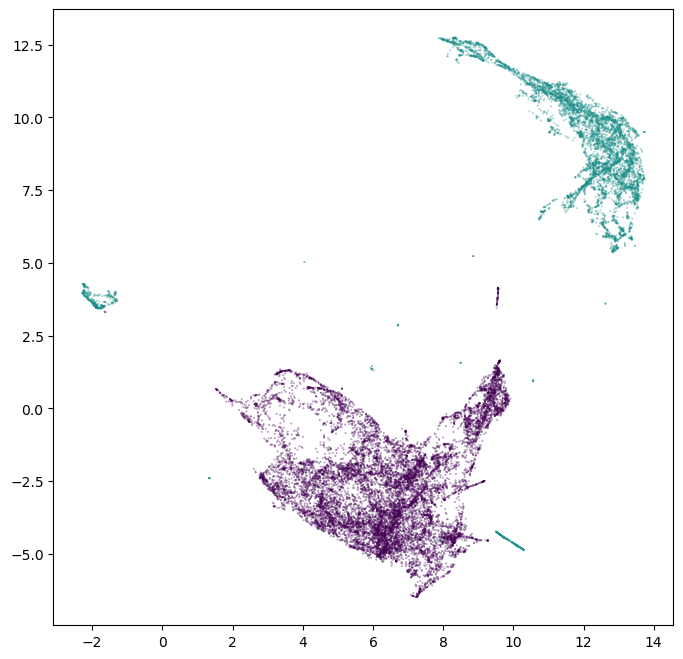

In [94]:
fig, ax = plt.subplots(figsize=(8, 8))

kwargs_hist = {
    'alpha': 0.6,
    's': 0.1}

ax.scatter(X_kssl_umap[:, 0], X_kssl_umap[:, 2], c=y_bin, **kwargs_hist)

### Simple classifier training

In [304]:
# Perform binning
num_bins = 2
bins, edges = np.histogram(y_kssl, bins=num_bins)

# Assign discrete labels based on binning
y_bin_kssl = np.digitize(y_kssl, edges)

print(f'bins: {bins}')
print(f'edges: {edges}')
print(f'edges (back-transformed): {10**edges}')

bins: [14092  6836]
edges: [-1.953946   -0.22216362  1.5096188 ]
edges (back-transformed): [1.1118700e-02 5.9956515e-01 3.2330971e+01]


In [332]:
y_bin_kssl = y_kssl > np.log10(0.6)

In [333]:
X_train, X_test, y_train, y_test, y_bin_train, y_bin_test = train_test_split(X_kssl, y_kssl, 
                                                                             y_bin_kssl, 
                                                                             test_size=0.2, 
                                                                             random_state=42)
print(f'# train: {len(X_train)}')
print(f'# test: {len(X_test)}')

# train: 16742
# test: 4186


In [342]:
reducer = umap.UMAP(n_neighbors=80,
                    metric='cosine',
                    n_components=10).fit(X_train, y=y_bin_train)

embedding_train = reducer.transform(X_train)


In [343]:
bp = Babyplot(background_color="#FFF", turntable=True)
bp.add_plot(embedding_train, "pointCloud", "categories", 
            y_bin_train, {"colorScale": "Dark1"})
#bp

<IPython.core.display.Javascript object>

In [344]:
# K-nearest classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(embedding_train, y_bin_train)

KNeighborsClassifier(n_neighbors=15)

In [345]:
knn.score(embedding_train, y_bin_train)

0.9996416198781508

In [346]:
y_train_hat = knn.predict(embedding_train)
print(f'Precision: {precision_score(y_bin_train, y_train_hat)}')
print(f'Recall: {recall_score(y_bin_train, y_train_hat)}')

Precision: 1.0
Recall: 0.9989090909090909


In [347]:
embedding_test = reducer.transform(X_test)
y_test_hat = knn.predict(embedding_test)

In [348]:
bp = Babyplot(background_color="#FFF", turntable=True)
bp.add_plot(embedding_test, "pointCloud", "categories", 
            y_bin_test, {"colorScale": "Dark1"})
#bp

<IPython.core.display.Javascript object>

In [349]:
print(f'Precision: {precision_score(y_bin_test, y_test_hat)}')
print(f'Recall: {recall_score(y_bin_test, y_test_hat)}')
print(f'f1_score: {f1_score(y_bin_test, y_test_hat)}')

Precision: 0.6913680781758957
Recall: 0.6397889977392615
f1_score: 0.6645792563600782


#### Mineralogical regions only

Based on: 
- Viscarra Rossel, R.A., 2011. Fine-resolution multiscale mapping of clay minerals in Australian soils measured with near infrared spectra. Journal of Geophysical Research: Earth Surface 116.


In [30]:
wl= np.arange(500, 2451)
kaolinite = 2165
illite = 2345
smectite = 1912

In [31]:
def get_indices(center_wl, bandwidth=25):
    idx_start = np.where(wl == (center_wl - bandwidth))
    idx_end = np.where(wl == (center_wl + bandwidth))
    return [idx[0].item() for idx in [idx_start, idx_end]]

idx_start, idx_end = get_indices(kaolinite)

In [38]:
mapper = umap.UMAP(n_neighbors=5,
                   metric='cosine').fit(X_all[:, idx_start:idx_end])

X_all_umap = mapper.fit_transform(X_all[:, idx_start:idx_end])

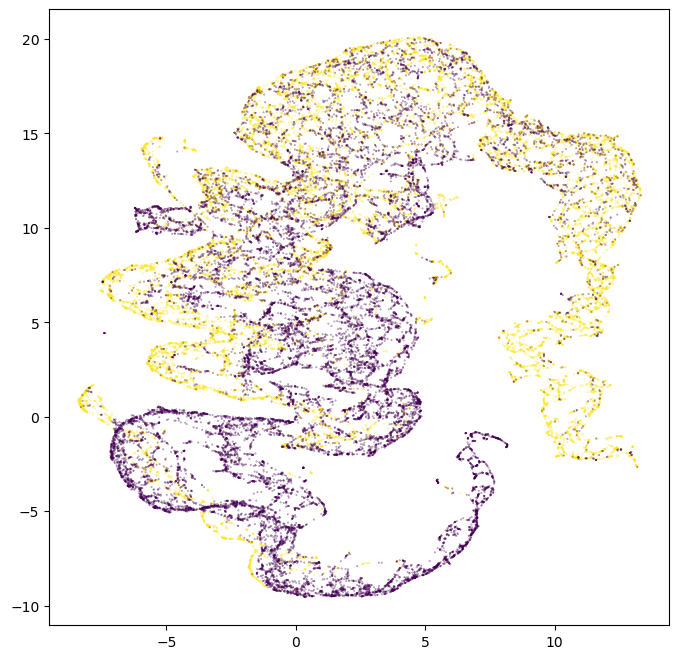

In [39]:
fig, ax = plt.subplots(figsize=(8, 8))

kwargs_hist = {
    'alpha': 0.6,
    's': 0.1}

ax.scatter(X_all_umap[:, 0], X_all_umap[:, 1], 
           c=labels, **kwargs_hist)

#ax.legend();